[Hjem (Github Pages)](https://madsjc.github.io/Bolig-site-analyse/)


1. [Webscrape script (Python)](https://github.com/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20Bolig-Scraper.py)
2. [Data Clean (Jupyter Notebook)](https://nbviewer.jupyter.org/github/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20-%20Data%20Clean.ipynb?flush_cache=true)
3. [***Exploratory Data Analysis - EDA (Jupyter Notebook)***](https://nbviewer.jupyter.org/github/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20-%20Exploratory%20Data%20Analysis%20%28EDA%29.ipynb?flush_cache=true)
4. [Live dashboard (Hosted ved Heroku)](https://mc-livebolig.herokuapp.com/)
5. [Live dashboard BACKEND (Plotly Dash)](https://github.com/MadsJC/Bolig-site-analyse/tree/master/Bolig_dashboard_live)

# Indhold i EDA notebook

1. [Indlæs data og intro](#chapter1)
2. [Visualisering af kategorier](#chapter2)
3. [Timeseries](#chapter3)
4. [Geografisk Visualisering](#chapter4)
5. [Correlations](#chapter5)


# 1. Indlæs data og intro <a class="anchor" id="chapter1"></a>
Her indlæser jeg de libraries jeg skal bruge og dataen jeg netop har rengjort i [data clean](https://nbviewer.jupyter.org/github/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20-%20Data%20Clean.ipynb?flush_cache=true)

In [1]:
# Generel Databehandling
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Vizulatations:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale=1.0)
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('cleaned_df.csv', sep=';')
df_org = df.copy()

print(f'Der er i alt {df.shape[0]} rows og {df.shape[1]} columns')

Der er i alt 35420 rows og 25 columns


In [3]:
print('Først 2 rows af den samlede data:')
df.head(2)

Først 2 rows af den samlede data:


,ids,titel,adresse,postnr,oprettelsesdato,oprettelsesdag,oprettelsesmåned,depositum,boligtype,etage,...,månedlig_leje,aconto,status,image_count,antal_værelser,kvadratmeter,månedlig_leje_kvadratmeter,navn,Longitude,Latitude
0,5911595,5 værelses lejlighed på 115 m²,"Thit Jensens Gade, 8000 Aarhus C - 7. sal",8000,2019-11-01,Friday,November,46500,Lejlighed,7. sal,...,15500,290,Udlejet,9,5,115,134.78,Aarhus C,10.278021,56.150515
1,5911633,4 værelses lejlighed på 96 m²,"Dirch Passers Gade, 8000 Aarhus C - 5. sal",8000,2019-11-01,Friday,November,38280,Lejlighed,5. sal,...,12760,600,Udlejet,21,4,96,132.92,Aarhus C,10.278021,56.150515


In [4]:
print('Hurtigt statiskisk overblik over den rengjorte data')
df[['depositum', 'månedlig_leje', 'aconto', 'image_count', 
    'antal_værelser', 'kvadratmeter', 'månedlig_leje_kvadratmeter']].describe()

Hurtigt statiskisk overblik over den rengjorte data


,depositum,månedlig_leje,aconto,image_count,antal_værelser,kvadratmeter,månedlig_leje_kvadratmeter
count,35420.000000,35420.000000,35420.000000,35420.000000,35420.000000,35420.000000,35420.000000
mean,22542.425353,7909.851045,573.781508,8.333682,2.751242,82.346753,112.144385
std,12975.647510,4098.051597,518.915819,6.508201,1.198538,40.045262,93.536654
min,0.000000,1309.000000,0.000000,0.000000,1.000000,1.000000,9.090000
25%,13600.000000,4999.000000,0.000000,4.000000,2.000000,59.000000,73.150000
50%,20400.000000,6997.000000,600.000000,7.000000,3.000000,80.000000,92.365000
75%,29049.000000,9795.000000,850.000000,12.000000,4.000000,104.000000,129.242500
max,118500.000000,45000.000000,12500.000000,72.000000,16.000000,1100.000000,11400.000000


# 2. Visualisering af kategorier <a class="anchor" id="chapter2"></a>
I dette afsnit vil jeg kort vise fordelingen af boligtyper og visualisere kategori-columns per boligtype

   boligtype  antal
0  Lejlighed  26728
1   Rækkehus   2945
2    Værelse   2925
3      Villa   2822


Text(0.5, 1.0, 'Fordeling af boligtyper')

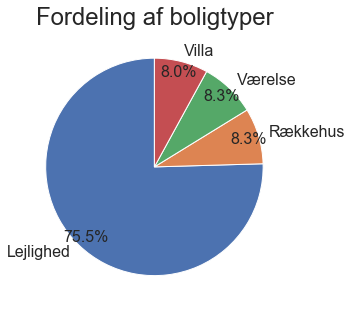

In [5]:
df_valuecounts_boligtyper = df['boligtype'].value_counts().reset_index().rename(columns={'index':'boligtype', 'boligtype':'antal'})
print(df_valuecounts_boligtyper)
plt.figure(figsize=(6,5))
plt.pie(x=df_valuecounts_boligtyper['antal'], labels=df_valuecounts_boligtyper['boligtype'], pctdistance=0.9, 
                  autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})
plt.title('Fordeling af boligtyper', fontsize=24)

Her ses at størtedelen (75%) af dataen er fra boligtypen "Lejlighed". Det vil selvfølgelig påvirke resten af analysen. Jeg kunne forsøge at normalisere dataen, så jeg nemmere kunne sammenligne mellem boligtyperne.
Det har jeg valgt ikke at gøre her - men fremadrettet skal jeg være opmærksom på, at 75% af alt dataen er lejligheder.

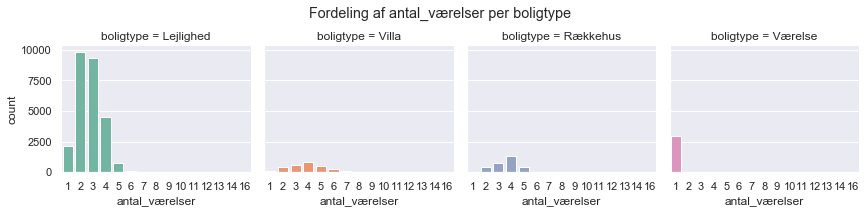

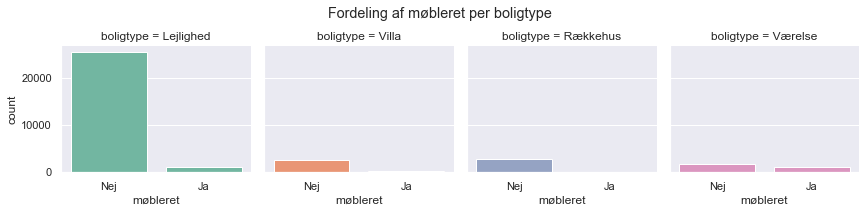

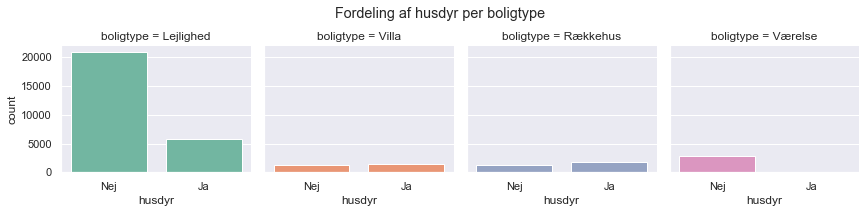

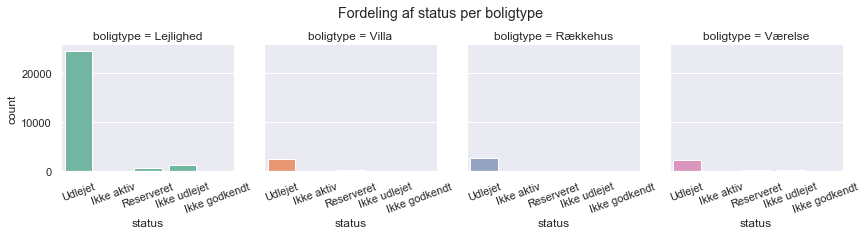

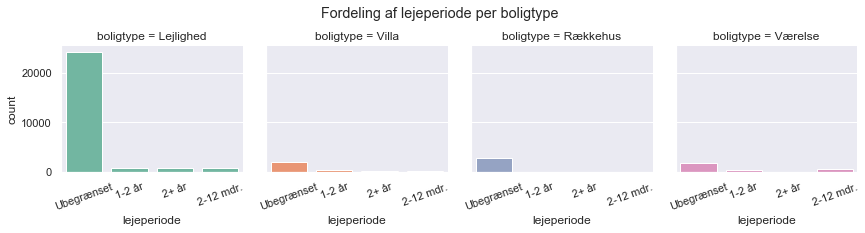

In [6]:
def make_cat_plot(slt_category_x, slt_facet_col='boligtype'):
    if slt_category_x in ['status', 'lejeperiode']:
        tick_rotaion = 20
    else:
        tick_rotaion = 0
        
    fig_cat = sns.catplot(x=slt_category_x, hue=slt_facet_col, col=slt_facet_col,
                    data=df, kind="count", palette="Set2",
                    height=3, dodge=False)
    plt.subplots_adjust(top=0.8)
    fig_cat.fig.suptitle('Fordeling af ' + slt_category_x + ' per ' + slt_facet_col)
    fig_cat.set_xticklabels(rotation=tick_rotaion)

    return fig_cat
    


cat_plot_list = ['antal_værelser', 'møbleret', 'husdyr', 'status', 'lejeperiode']

for i in cat_plot_list:
    make_cat_plot(i)

# 3. Timeseries <a class="anchor" id="chapter3"></a>
Laver en ny funktion der kan illustrere summen af månedlig_leje og antal oprettede boliger per oprettelsesdato

### 3.1 - Kummuleret månedlig_leje (dkk)

In [7]:
def make_timeseries_plot(slt_calculation, slt_column):
    
    if slt_calculation == 'Sum':   
        df_timeseries_1 = df.groupby(['oprettelsesdato'], as_index=False)[slt_column].sum()
        df_timeseries_2 = df.groupby(['oprettelsesdato', 'boligtype'], as_index=False)[slt_column].sum()
        titel = f'{slt_calculation} of {slt_column} (dkk) per oprettelsesdato'

        
    elif slt_calculation == 'Count':   
        df_timeseries_1 = df.groupby(['oprettelsesdato'], as_index=False)[slt_column].count()
        df_timeseries_2 = df.groupby(['oprettelsesdato', 'boligtype'], as_index=False)[slt_column].count()
        titel = f'{slt_calculation} of created entities per oprettelsesdato'
        
    else:
        return "Available options for 'slt_calculation' are Sum & Count"



    fig_timeseries_1 = px.line(df_timeseries_1, x='oprettelsesdato', y=slt_column, 
                               title='Total ' + titel)
    fig_timeseries_1.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=2, label="2m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig_timeseries_2 = px.line(df_timeseries_2, x='oprettelsesdato', y=slt_column, 
                               title=titel + ' (Per boligtype)', facet_col="boligtype", facet_col_wrap=2)

    return fig_timeseries_1.show(renderer='notebook_connected'), fig_timeseries_2.show(renderer='notebook_connected')

In [8]:
make_timeseries_plot('Sum', 'månedlig_leje')
make_timeseries_plot('Count', 'ids')

(None, None)

### 3.2 - Ugedage og månedsplot
Det virker til at alle boligtyperne har nogle gennemgående udsving. Det kunne tyde på, at der er nogle bestemte ugedage der er mere populære at oprette boliger på end andre. Det undersøger jeg herunder.

Text(0.5, 1.0, 'Antal oprettede boliger per ugedag')

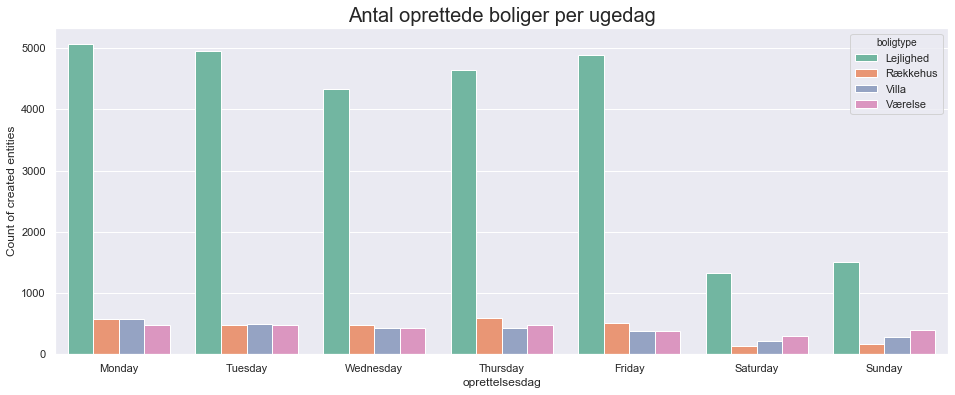

In [9]:
df_weekday_bar = df.groupby(['oprettelsesdag', 'boligtype'], as_index=False)['ids'].count()
df_weekday_bar = df_weekday_bar.rename(columns={'ids':'Count of created entities'})

weekday_order = ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(16,6))
sns.barplot(x="oprettelsesdag", y="Count of created entities", palette="Set2", 
                 hue='boligtype', data=df_weekday_bar, order=weekday_order)
plt.title('Antal oprettede boliger per ugedag', fontsize=20)

Det kan tydeligt ses i ovenstående barplot at der generelt bliver oprettet mindre boliger i weekenden. Især Lejligheder ser et stort fald i weekenden, mens Værelser har en mindre nedgang. 

Jeg gentager det samme med måneder.

*OBS: Vær opmærksom på at jeg ikke har scrapet hele februar, hvilket gør sammenligningsgrundlaget herunder svagt.*

In [10]:
for i in df['oprettelsesmåned'].unique():
    min_val = pd.to_datetime(df[df['oprettelsesmåned'] == i]['oprettelsesdato'].min())
    max_val = pd.to_datetime(df[df['oprettelsesmåned'] == i]['oprettelsesdato'].max())
    min_val_str = min_val.strftime('%d-%m-%Y')
    max_val_str = max_val.strftime('%d-%m-%Y')
    
    print(f'{i}:')
    print('Første dato: ' + min_val_str)
    print('Sidste dato: ' + max_val_str)
    print('Total antal dage: ' + str(max_val - min_val)[:7] + '\n' + '▔▔▔▔▔▔▔▔▔▔▔▔▔▔')

November:
Første dato: 01-11-2019
Sidste dato: 30-11-2019
Total antal dage: 29 days
▔▔▔▔▔▔▔▔▔▔▔▔▔▔
December:
Første dato: 01-12-2019
Sidste dato: 31-12-2019
Total antal dage: 30 days
▔▔▔▔▔▔▔▔▔▔▔▔▔▔
January:
Første dato: 01-01-2020
Sidste dato: 31-01-2020
Total antal dage: 30 days
▔▔▔▔▔▔▔▔▔▔▔▔▔▔
February:
Første dato: 01-02-2020
Sidste dato: 07-02-2020
Total antal dage: 6 days 
▔▔▔▔▔▔▔▔▔▔▔▔▔▔


Text(0.5, 1.0, 'Antal oprettede boliger per måned')

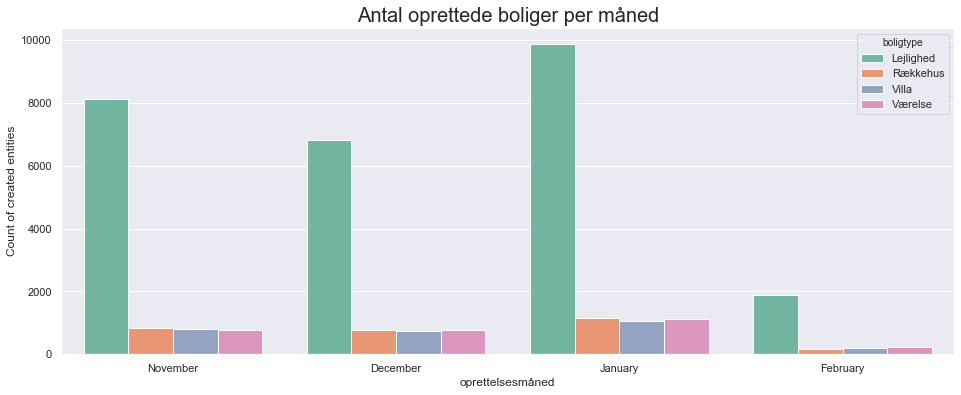

In [11]:
df_month_bar = df.groupby(['oprettelsesmåned', 'boligtype'], as_index=False)['ids'].count()
df_month_bar = df_month_bar.rename(columns={'ids':'Count of created entities'})
month_order = ['November','December','January','February']

plt.figure(figsize=(16,6))
sns.barplot(x="oprettelsesmåned", y="Count of created entities", palette="Set2",
                 hue='boligtype', data=df_month_bar, order=month_order)
plt.title('Antal oprettede boliger per måned', fontsize=20)

Generelt flere oprettelser i januar måned. (februars lave tal skyldes selvfølgelig at det kun er 6 dages data)

### 3.3 - Pivot table - Oprettelser per boligtype, ugenr. og ugedag


In [12]:
# Laver en nu column med uge-nr.
df['oprettelsesweek_num'] = pd.to_datetime(df['oprettelsesdato']).dt.week
df['oprettelsesyear'] = pd.to_datetime(df['oprettelsesdato']).dt.year

weekdays = {"Monday": "1. Monday", "Tuesday": "2. Tuesday", "Wednesday": "3. Wednesday", 
            "Thursday": "4. Thursday", "Friday": "5. Friday", "Saturday": "6. Saturday", "Sunday": "7. Sunday"}


df['oprettelsesdag_num'] = df['oprettelsesdag'].map(weekdays)

In [13]:
# Laver pivot table
df_pivot_oprettelse = pd.pivot_table(df, values='ids', index=['boligtype', 'oprettelsesdag_num'],
                                     columns=['oprettelsesyear', 'oprettelsesweek_num'], aggfunc='count').fillna(0)
df_pivot_oprettelse

oprettelsesyear                2019                                            \
oprettelsesweek_num              1      44     45     46     47     48     49   
boligtype oprettelsesdag_num                                                    
Lejlighed 1. Monday           243.0    0.0  400.0  297.0  317.0  363.0  419.0   
          2. Tuesday           53.0    0.0  387.0  394.0  415.0  327.0  536.0   
          3. Wednesday          0.0    0.0  450.0  292.0  292.0  392.0  312.0   
          4. Thursday           0.0    0.0  416.0  268.0  269.0  274.0  301.0   
          5. Friday             0.0  286.0  446.0  325.0  341.0  224.0  283.0   
          6. Saturday           0.0   95.0   67.0   71.0  206.0   87.0   60.0   
          7. Sunday             0.0  110.0   96.0  111.0   98.0  106.0  122.0   
Rækkehus  1. Monday            49.0    0.0   64.0   35.0   39.0   35.0   36.0   
          2. Tuesday            5.0    0.0   42.0   34.0   37.0   21.0   56.0   
          3. Wednesday          0.0    0.0   53.0   24.0   24.0   40.0   36.0   
          4. Thursday           0.0    0.0   44.0   52.0   25.0   41.0   53.0   
          5. Friday             0.0   17.0   33.0   35.0   40.0   15.0   39.0   
          6. Saturday           0.0    9.0    4.0    9.0   16.0    7.0    5.0   
          7. Sunday             0.0   10.0    9.0   13.0    9.0    9.0   30.0   
Villa     1. Monday            32.0    0.0   37.0   34.0   31.0   30.0   28.0   
          2. Tuesday           15.0    0.0   32.0   35.0   29.0   30.0   45.0   
          3. Wednesday          0.0    0.0   39.0   33.0   29.0   35.0   37.0   
          4. Thursday           0.0    0.0   27.0   22.0   36.0   25.0   36.0   
          5. Friday             0.0   31.0   36.0   25.0   21.0   20.0   25.0   
          6. Saturday           0.0   14.0   13.0   11.0   26.0   18.0   11.0   
          7. Sunday             0.0   31.0   24.0   22.0   17.0   18.0   22.0   
Værelse   1. Monday            28.0    0.0   27.0   30.0   35.0   39.0   29.0   
          2. Tuesday           12.0    0.0   36.0   39.0   25.0   32.0   36.0   
          3. Wednesday          0.0    0.0   31.0   25.0   28.0   27.0   33.0   
          4. Thursday           0.0    0.0   28.0   25.0   23.0   46.0   26.0   
          5. Friday             0.0   27.0   20.0   17.0   14.0   30.0   21.0   
          6. Saturday           0.0   15.0   15.0   18.0   25.0   16.0   21.0   
          7. Sunday             0.0   25.0   17.0   23.0   25.0   36.0   35.0   

oprettelsesyear                                     2020                       \
oprettelsesweek_num              50     51     52     1      2      3      4    
boligtype oprettelsesdag_num                                                    
Lejlighed 1. Monday           343.0  254.0  133.0    0.0  515.0  573.0  377.0   
          2. Tuesday          347.0  379.0   27.0    0.0  407.0  457.0  400.0   
          3. Wednesday        256.0  281.0   91.0   82.0  385.0  404.0  323.0   
          4. Thursday         346.0  364.0   68.0  451.0  397.0  428.0  386.0   
          5. Friday           517.0  291.0  215.0  393.0  367.0  415.0  330.0   
          6. Saturday          58.0   51.0  102.0  136.0   85.0   94.0  105.0   
          7. Sunday           106.0   94.0   66.0  150.0   98.0  121.0  110.0   
Rækkehus  1. Monday            47.0   25.0   20.0    0.0   45.0   45.0   60.0   
          2. Tuesday           37.0   22.0    4.0    0.0   44.0   49.0   40.0   
          3. Wednesday         31.0   40.0    8.0   10.0   53.0   48.0   42.0   
          4. Thursday          18.0   47.0   11.0   55.0   45.0   53.0   75.0   
          5. Friday            38.0   48.0   17.0   56.0   31.0   61.0   39.0   
          6. Saturday           5.0    7.0   15.0   11.0   19.0   10.0   12.0   
          7. Sunday             8.0    5.0   13.0   16.0   12.0   11.0   15.0   
Villa     1. Monday            28.0   27.0   17.0    0.0   43.0  169.0   31.0   
          2. Tuesday          

*OBS: d. 30-12-2019 og 31-12-2019 er teknisk set uge 1 i 2019*

# 4. Geografisk visualisering <a class="anchor" id="chapter4"></a>
I dette afsnit vil jeg kort vise top 3 byer per boligtype og indsætte alt dataen i et interaktiv kort

In [14]:
for i in df['boligtype'].unique():
    temp_df = df[df['boligtype'] == i]
    temp_df_con = pd.concat([temp_df['navn'].value_counts()[:3], 
           temp_df['navn'].value_counts(normalize=True)[:3] * 100], 
          axis=1, keys=('Antal', 'Procent'), sort=False)
    print(i + ':')
    print(temp_df_con)
    print()

Lejlighed:
             Antal   Procent
Aalborg       2293  8.579018
Aarhus C      1593  5.960042
København S   1371  5.129452

Villa:
             Antal   Procent
Svenstrup J    174  6.165840
Vejle           86  3.047484
Viborg          47  1.665485

Rækkehus:
           Antal    Procent
Silkeborg    418  14.193548
Herning      132   4.482173
Vejle        123   4.176570

Værelse:
             Antal    Procent
Aarhus C       313  10.700855
København S    197   6.735043
Aalborg        161   5.504274



Som forventet er det de største byer der dominerer Lejligheder- og Værelser-boligtyperne. Det springer umiddelbart i øjnene at 6% af alle Villa'er oprettet i dataen er fra Svenstrup J.

In [15]:
df_villa_svenstrupj = df[(df['boligtype'] == 'Villa') & (df['navn'] == 'Svenstrup J')]['adresse']
print(f'Adresse for villaer i Svenstrup J: (ialt: {df_villa_svenstrupj.shape[0]} villaer)')
df_villa_svenstrupj.value_counts()

Adresse for villaer i Svenstrup J: (ialt: 174 villaer)


Toftegårdsvej, 9230 Svenstrup J           96
Carl Scharnbergs Vej, 9230 Svenstrup J    27
Valhal, 9230 Svenstrup J                  15
Hovedgaden, 9230 Svenstrup J              13
Svanelundsbakken, 9230 Svenstrup J         3
Stygge Krumpens Vej, 9230 Svenstrup J      2
Skråvej, 9230 Svenstrup J                  2
Skovmærkevej, 9230 Svenstrup J             2
Ålborgvej, 9230 Svenstrup J                2
Gåsevej, 9230 Svenstrup J                  1
Klerkegade, 9230 Svenstrup J               1
Ingstrupvej, 9230 Svenstrup J              1
Bag Diget, 9230 Svenstrup J                1
Hedeageren, 9230 Svenstrup J               1
Bredgade, 9230 Svenstrup J                 1
Hedevangen, 9230 Svenstrup J               1
Offerlunden, 9230 Svenstrup J              1
Godthåbsvej, 9230 Svenstrup J              1
Østergade, 9230 Svenstrup J                1
Hobrovej, 9230 Svenstrup J                 1
Munkegade, 9230 Svenstrup J                1
Name: adresse, dtype: int64

Som ses herover og efter nogle google-søgninger, så virker villaerne i Svenstrup dog reelle nok - på trods af at 96 af dem er fra samme vej.

### 4.1 - Fordeling af boligtyper i landet

In [16]:
mapbox_access_token = 'pk.eyJ1IjoibWFkc2pjIiwiYSI6ImNrZWN3YzF6bjAwcDUyc3Q1OWc1amJhaDEifQ.MTO6xHwzu-9FJopzujIHlw'
px.set_mapbox_access_token(mapbox_access_token)

df_map = df.copy()
df_map['navn'] = df_map['navn'].apply(lambda x: x.split(' ')[0])

df_map = df.groupby(['navn', 'boligtype'], as_index=False).agg({'Latitude':'mean', 'Longitude':'mean', 'adresse':'count'})
df_map = df_map.rename(columns={'adresse':'Antal'})

fig_mapbox = px.scatter_mapbox(df_map, lat="Latitude", lon="Longitude",
                          color="boligtype", size='Antal', 
                          color_continuous_scale=px.colors.cyclical.IceFire, size_max=25, zoom=5.69)
fig_mapbox.update_layout(
    mapbox = dict(
        style =  "outdoors",
        center=go.layout.mapbox.Center(lat=56.263, lon=10.501)
        ))

fig_mapbox.show(renderer='notebook_connected')

*OBS: De fundne Longitude og Langtitude-værdier har ikke været så præcise som ønsket. Zoomes der ind på Nordjylland kan der ses flere boliger i Skagerrak*

# 5. Correlations <a class="anchor" id="chapter5"></a>
For at få en hurtig ide om Correlations i columns, laver jeg nedenstående heatmap

Text(0.5, 1, 'Alle boligtyper samlet')

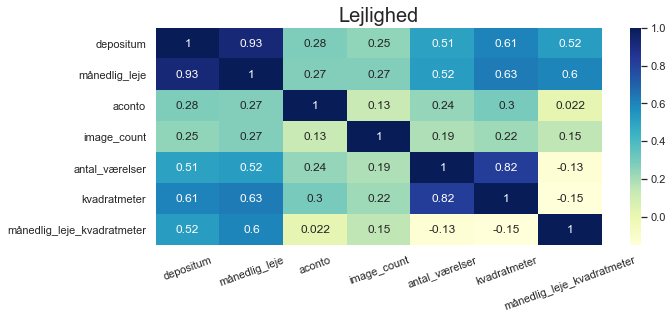

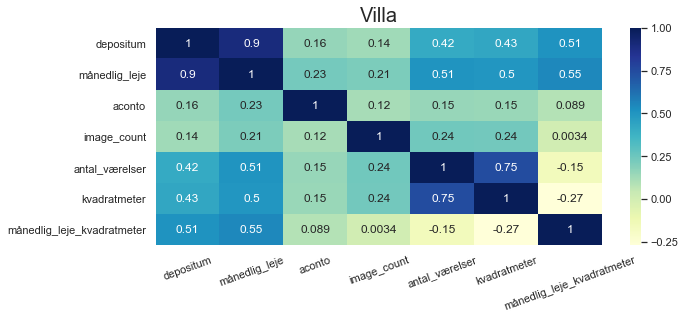

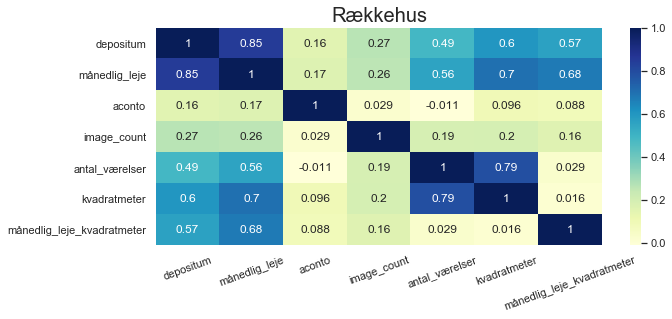

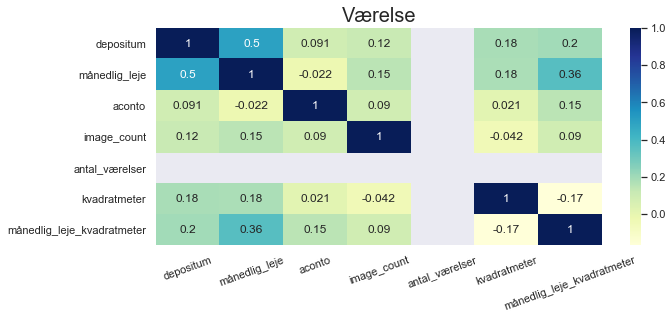

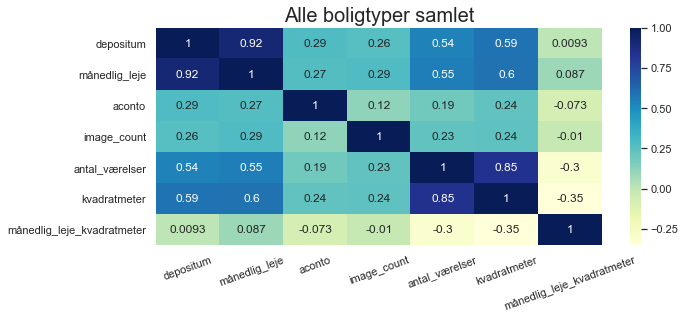

In [17]:
corr_columns_of_interest = ['oprettelsesdato', 'oprettelsesdag',
       'oprettelsesmåned', 'depositum', 'boligtype', 'etage', 'møbleret',
       'delevenlig', 'husdyr', 'lejeperiode', 'overtagelsesdato',
       'månedlig_leje', 'aconto', 'status', 'image_count', 'antal_værelser',
       'kvadratmeter', 'månedlig_leje_kvadratmeter']


#For hver boligtype
for i in df['boligtype'].unique():
    fig, ax = plt.subplots(figsize=(10,4))
    sns.heatmap(df[df['boligtype'] == i][corr_columns_of_interest].corr(), annot=True, ax=ax, cmap="YlGnBu")
    plt.xticks(rotation=20)
    plt.title(i, fontsize=20)

#Alle boligtyper samlet
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(df[corr_columns_of_interest].corr(), annot=True, ax=ax, cmap="YlGnBu")
plt.xticks(rotation=20)
plt.title('Alle boligtyper samlet', fontsize=20)

In [18]:
def make_corr_JointGrid(slt_x, slt_y, slt_xlim, slt_ylim):
    corr_plot = sns.JointGrid(data=df, x=slt_x, y=slt_y, xlim=slt_xlim, ylim=slt_ylim, height=7, ratio=3)
    corr_plot.plot_joint(sns.regplot, x_jitter=.5)
    corr_plot.plot_marginals(sns.distplot, kde=True)

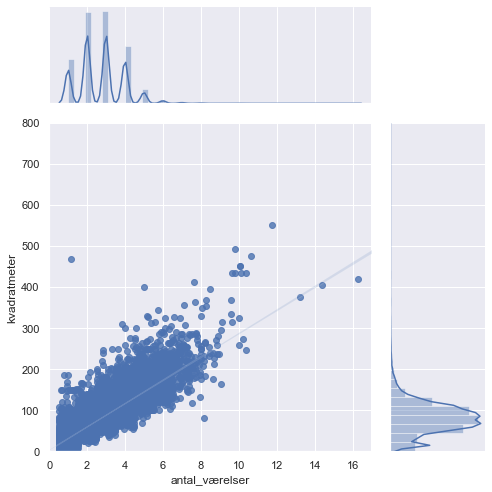

In [19]:
make_corr_JointGrid('antal_værelser', 'kvadratmeter', (0, 17), (0, 800))

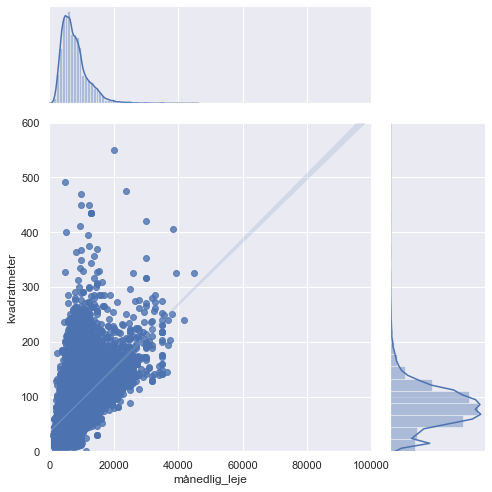

In [20]:
make_corr_JointGrid('månedlig_leje', 'kvadratmeter', (0, 100000), (0, 600))

[Hjem (Github Pages)](https://madsjc.github.io/Bolig-site-analyse/)


1. [Webscrape script (Python)](https://github.com/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20Bolig-Scraper.py)
2. [Data Clean (Jupyter Notebook)](https://nbviewer.jupyter.org/github/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20-%20Data%20Clean.ipynb?flush_cache=true)
3. [***Exploratory Data Analysis - EDA (Jupyter Notebook)***](https://nbviewer.jupyter.org/github/MadsJC/Bolig-site-analyse/blob/master/PYTHON%20-%20Exploratory%20Data%20Analysis%20%28EDA%29.ipynb?flush_cache=true)
4. [Live dashboard (Hosted ved Heroku)](https://mc-livebolig.herokuapp.com/)
5. [Live dashboard BACKEND (Plotly Dash)](https://github.com/MadsJC/Bolig-site-analyse/tree/master/Bolig_dashboard_live)